In [1]:
from libs.lr_finder import LRFinder
from config import Config


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting

# Import Image Libraries - Pillow and OpenCV
from PIL import Image
import cv2

# Import PyTorch and useful fuctions
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models # Pre-Trained models


# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.model_selection import train_test_split

import time
from datetime import datetime
from tqdm import tqdm_notebook

import os
import random

# User-defined modules
from train_dataset import transforms_train, transforms_valid, CreateDataset
from config import Config

from logger import Logger

# Open source libs


def add_data_to_loggers(loggers_list, column_name, data):
    loggers_list[0].add_data(column_name, data)
    loggers_list[1].add_data(column_name, data)

# FOR DETERMINISTIC RESLTS
from config import seed_torch

def __init_fn(worker_id):
    np.random.seed(13 + worker_id)

def main(batch_size, lr, p_horizontalflip, model_type, info):
    ## CONFIG!
    cfg = Config(batch_size=batch_size, lr=lr, p_horizontalflip=p_horizontalflip, model_type=model_type)

    ## REPRODUCIBILITY
    seed_torch(cfg.seed)


    print(os.listdir("./input"))
    base_dir = "./input"

    # Loading Data + EDA

    train_new_csv = pd.read_csv('./input/train_new.csv')
    train_old_csv = pd.read_csv('./input/train_old.csv')
    train_csv = None
    train_path = None
    if cfg.data_type == 'new_old_mixed':
        train_csv = pd.concat([train_new_csv, train_old_csv], axis=0)
        train_path = './input/train_mixed_images/'
    test_csv = pd.read_csv('./input/test.csv')
    print('Train Size = {}'.format(len(train_csv)))
    print('Public Test Size = {}'.format(len(test_csv)))

    counts = train_csv['diagnosis'].value_counts()
    class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
    for i, x in enumerate(class_list):
        counts[x] = counts.pop(i)
        print("{:^12} - class examples: {:^6}".format(x, counts[x]))

    # Data Processing


    ## SHUFFLE DATA
    train_csv, valid_csv = train_test_split(train_csv, test_size=cfg.valid_size,  shuffle=True, random_state=cfg.seed)
    train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=transforms_train)
    valid_data = CreateDataset(df_data=valid_csv, data_dir=train_path, transform=transforms_valid)

    # obtain training indices that will be used for validation


    # Create Samplers


    # prepare data loaders (combine dataset and sampler)
    train_loader = DataLoader(train_data, batch_size=cfg.batch_size,
                              pin_memory=True,
                              num_workers=cfg.num_workers,
                              shuffle=True,
                              worker_init_fn=__init_fn)

    valid_loader = DataLoader(valid_data, batch_size=cfg.batch_size,
                              pin_memory=True,
                              num_workers=cfg.num_workers,
                              shuffle=True,
                              worker_init_fn=__init_fn)

    # Model

    # check if CUDA is available
    train_on_gpu = torch.cuda.is_available()

    if not train_on_gpu:
        print('CUDA is not available.  Training on CPU ...')
    else:
        print('CUDA is available!  Training on GPU ...')
        cfg.model = cfg.model.cuda()

    # Trainable Parameters
    print("Number of trainable parameters: \n{}".format(cfg.pytorch_total_params))

    #Training(Fine-Tuning) and Validation
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    lr_finder = LRFinder(cfg.model, cfg.optimizer, cfg.criterion, device='cuda')
    lr_finder.range_test(train_loader, end_lr=2, num_iter=500)
    lr_finder.plot(log_lr=True)
    


['sample_submission.csv', 'train_old_o.csv', 'test_images', 'train_old.csv', 'train_new_images', 'EfficientNet_PyTorch', 'train_new.csv', 'train_mixed_images', 'pretrained-models', 'test.csv', 'train_old_images']
Train Size = 38788
Public Test Size = 1928
   No DR     - class examples: 27615 
    Mild     - class examples:  2813 
  Moderate   - class examples:  6291 
   Severe    - class examples:  1066 
Proliferate  - class examples:  1003 
CUDA is available!  Training on GPU ...
Number of trainable parameters: 
28342833


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


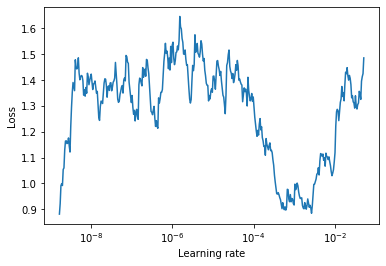

In [5]:
main(16, 1e-9, 0.7, 'efficientnet-b5', 'blah')